In [1]:


# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
import matplotlib
from scipy import constants
from numpy.polynomial import Polynomial
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import seaborn as sns
import pandas as pd

In [2]:
import os
print(os.path.abspath("."))

/Users/proden/Code/SCQED-PCQED/src


In [3]:
#calculate some constants for HH

amu_to_au = 1822.89


mA_kg = 1.00784 * (10 ** (-3) / (6.022 * 10 ** 23) )
mB_kg = 1.00784  * (10 ** (-3) / (6.022 * 10 ** 23) )
mA_au = 1.00784 * amu_to_au
mB_au = 1.00784 * amu_to_au
mu_au = (mA_au * mB_au )/ (mA_au + mB_au)
mu_kg = (mA_kg * mB_kg) / (mA_kg + mB_kg)  
print("mu_au: ", mu_au)

mu_au:  918.5907288000001


In [203]:
import warnings
from scipy.signal import find_peaks


def declutter_E_array(E_array, dipoles,  r_data, discontinuity_threshold_std = 2, energy_diff_threshold_std = 2,  num_to_declutter = 2, upper_triangular_dipoles = True):

    if upper_triangular_dipoles:
        for r_ in range(0, dipoles.shape[3]):

            for i in range(0, dipoles.shape[0]):
                for j in range(i, dipoles.shape[0]):

                    dipoles[j,i, :, r_] =  dipoles[i,j, :, r_]


    
    E_array_copy = np.array(E_array, copy = True)


    for crossover_nums in range(0,3):

        d_matrices = np.zeros((num_to_declutter , num_to_declutter, r_data.shape[0]) )
        d_matrices[d_matrices < 10**-11] = 0
        diff_d_matrices =  np.zeros((num_to_declutter , num_to_declutter, r_data.shape[0]-1))

        def build_dipole_mag_matrix(dipoles, n_elec, r_):

            
            d_matrix = np.zeros((n_elec,n_elec))

            def vector_magnitude(vector):
                return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


            for i in range(n_elec):
                for j in range(n_elec):
                    d_matrix[i][j] = vector_magnitude(dipoles[i,j,:,r_])


            #d_matrix = d_matrix + d_matrix.T - np.diag(np.diag(d_matrix))

            return d_matrix
        
        
        
        for i in range(0, r_data.shape[0] ):
            d_matrices[:, : , i] = build_dipole_mag_matrix(dipoles, num_to_declutter, i)

        diff_d_matrices = np.diff(d_matrices)
        diff_d_matrices[diff_d_matrices < 10**-11] = 0



        #store discontinyutity locs as a list of lists like  
        # [   [loc, surface_1]  ,     [loc, surface_1] , [loc, surface_1] ]
        #find all discontinutiniutiy locations based on continutity of transition dipoles and dipoles
        discontinuity_locs = []


        previous_intersection = 0 
        for i in range(0,num_to_declutter): 

            for j in range(i, num_to_declutter):
                dipoles_diff = diff_d_matrices[i,j, previous_intersection:]

                peaks_1 = find_peaks( np.abs(np.diff(dipoles_diff)) , prominence= np.mean(np.abs(np.diff(dipoles_diff))) * discontinuity_threshold_std)

                idx_1= peaks_1[0]+2
                

                #plt.plot(diff_d_matrices[i, j, previous_intersection:])

                if len(idx_1) != 0:
                    #getting first point of crossover
                    if len(idx_1) > 1:
                        idx_1_copy = idx_1.copy()
                        while(len(idx_1_copy) > 0 ):
                            #print(idx_1_copy)
                            crossover_loc = None
                            for q in range(len(idx_1_copy) - 1):
                                #print(idx_1_copy)
                                if idx_1_copy[q] +1 == idx_1_copy[q+1]:
                                    #print("hello")
                                    idx_1_copy = idx_1_copy[q+1:]
                                    pass
                                else:
                                    crossover_loc = idx_1_copy[q]

                                    discontinuity_locs.append([crossover_loc, j])
                                    try:
                                        idx_1_copy = idx_1_copy[q+1:]
                                    except():
                                        idx_1_copy = []
                                        break

                                    break

                                if len(idx_1_copy == 1):
                                    break

                            if len(idx_1_copy) == 1:    
                                idx_1_copy = []
                                discontinuity_locs.append([idx_1[-1], j])
                                break                
                        
                    elif len(idx_1) == 1:
                        discontinuity_locs.append([idx_1[0], j])


        #sort and remove repaets
        discontinuity_locs  = [list(x) for x in set(tuple(x) for x in discontinuity_locs )]
        discontinuity_locs = sorted(discontinuity_locs, key=lambda x: x[0])
        #print(discontinuity_locs)

        #store discontinity locations like this
        # [   [loc, surface_1, surface_2]  ,     [loc, surface_1, surface_2] , [loc, surface_1, surface_2] ]
        #find all discontinutiniutiy locations based on continutity of transition dipoles and dipoles

        new_discontinuity_locs = []
        for q in range(len(discontinuity_locs)):
            loc1 = discontinuity_locs[q]
            for w in range(len(discontinuity_locs)):
                if w != q:
                    loc2 = discontinuity_locs[w]

                    if loc1[1] != loc2[1]:

                        if loc1[0] == loc2[0]:
                            new_discontinuity_locs.append([loc1[0] ,discontinuity_locs[q][1], discontinuity_locs[w][1]])

                        if loc1[0] == loc2[0] -1:
                            new_discontinuity_locs.append([loc2[0] ,discontinuity_locs[q][1], discontinuity_locs[w][1]])

                        if loc1[0] -1 == loc2[0]:
                            new_discontinuity_locs.append([loc1[0] ,discontinuity_locs[q][1], discontinuity_locs[w][1]])

        #sort and remove repeats again
        discontinuity_locs = new_discontinuity_locs
        # we need to remove one of these [loc, 1,2] and [loc, 2,1]
        for i in range(len(discontinuity_locs)):
            if discontinuity_locs[i][1] > discontinuity_locs[i][2]:

                copy = discontinuity_locs[i][2] 
                discontinuity_locs[i][2] = discontinuity_locs[i][1] 
                discontinuity_locs[i][1] = copy

        discontinuity_locs  = [list(x) for x in set(tuple(x) for x in discontinuity_locs )]
        discontinuity_locs = sorted(discontinuity_locs, key=lambda x: x[0])


        #for every discontinuity loc check and see if energies are very close using standard deviations of differences
        #crossover energy arrays

        crossover_points = []
        for i in range(len(discontinuity_locs)):
            loc = discontinuity_locs[i]

            array1 = E_array[:, loc[1]]
            array2 = E_array[:, loc[2]]


            #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
            diff_array1 = np.diff(array1 )
            diff_array2 = np.diff(array2 )
            std1 = np.std(np.abs(diff_array1))
            mean1 = np.mean(np.abs(diff_array1))
            std2 = np.std(np.abs(diff_array2))
            mean2 = np.mean(np.abs(diff_array2))
            energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
            #find closest points
            #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
            closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)[0]
            if loc[0] in closest_indices:

                crossover_points.append(loc)

            
        # a few points are like this :[1084, 3, 4] ,[1085, 3, 4], choose the larger one
        indices_to_pop = []
        for i in range(len(crossover_points)-1):
            if crossover_points[i][1] == crossover_points[i+1][1] and crossover_points[i][2] == crossover_points[i+1][2]:
                if crossover_points[i][0] +1 == crossover_points[i+1][0]:
                    indices_to_pop.append(i)
        indices_to_pop.sort()
        indices_to_pop.reverse()
        for i in indices_to_pop:
            crossover_points.pop(i)

        print(crossover_points)
        #only get first crossover in list
        crossover_points = [crossover_points[0]]


        #perform crossover:
        for i in range(len(crossover_points)):


            idx = crossover_points[i][0]  + 1

            array1 = E_array[:, crossover_points[i][1]]
            array2 = E_array[:, crossover_points[i][2]]

            array1_copy = np.array(array1, copy=True)
            array1 = np.concatenate([array1[:idx],  array2[idx:]])
            array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])

            E_array[:,crossover_points[i][1]] = array1
            E_array[:,crossover_points[i][2]] = array2


            #go in and change crossover points to reflect changes in E_array
            surface_1 = crossover_points[i][1]
            surface_2 = crossover_points[i][2] 


            for p in range(len(crossover_points)):

                if crossover_points[p][1] == surface_1:
                    crossover_points[p][1] = surface_2

                elif crossover_points[p][1] == surface_2:
                    crossover_points[p][1] = surface_1

                if crossover_points[p][2] == surface_1:
                    crossover_points[p][2] = surface_2

                elif crossover_points[p][2] == surface_2:
                    crossover_points[p][2] = surface_1


        #reorder dipole array based off that crossover to repeat
        crossover_point = crossover_points[0][0] 
        surface_1 = crossover_points[0][1]  
        surface_2 = crossover_points[0][2]      

        print(crossover_point)     


        plt.plot(d_matrices[0,4, :])
        plt.show()

        plt.plot(d_matrices[0,3, :])
        plt.show()



        for r_ in range(crossover_point, dipoles.shape[3]):
            for switch_num in range(dipoles.shape[0]):

                holder = dipoles[switch_num, surface_1, :, r_]
                dipoles[switch_num, surface_1, :, r_] = dipoles[switch_num, surface_2, :, r_]
                dipoles[switch_num, surface_2, :, r_] = holder


                holder = dipoles[surface_1, switch_num, :, r_]
                dipoles[surface_1, switch_num, :, r_] = dipoles[surface_2, switch_num, :, r_]
                dipoles[surface_2, switch_num, :, r_] = holder


    return E_array


In [204]:
print(dipoles_0.shape)

(12, 12, 3, 2500)


[[492, 3, 4], [1061, 4, 5], [1085, 3, 4], [1296, 4, 5], [1863, 6, 7]]
492


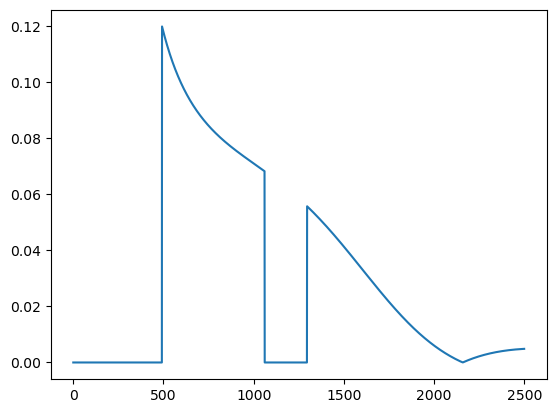

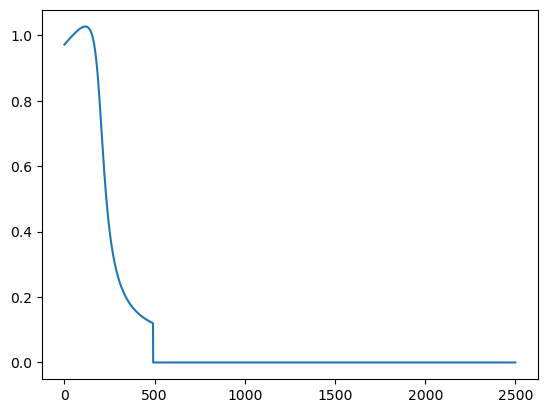

[[1085, 3, 4], [1863, 6, 7]]
1085


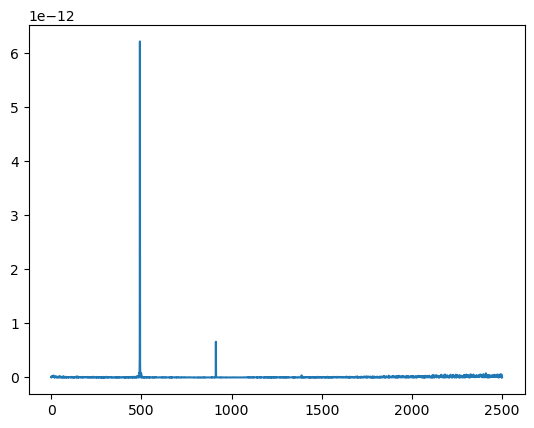

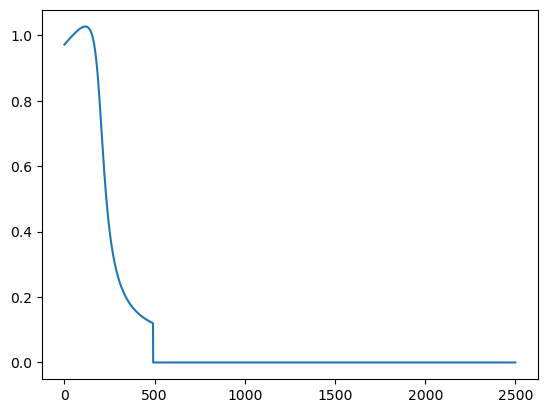

[[1085, 3, 4], [1863, 6, 7]]
1085


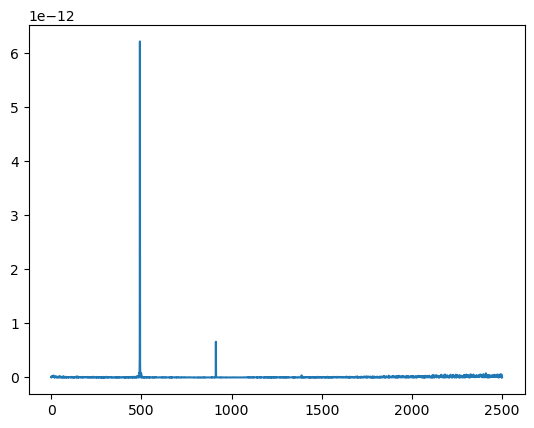

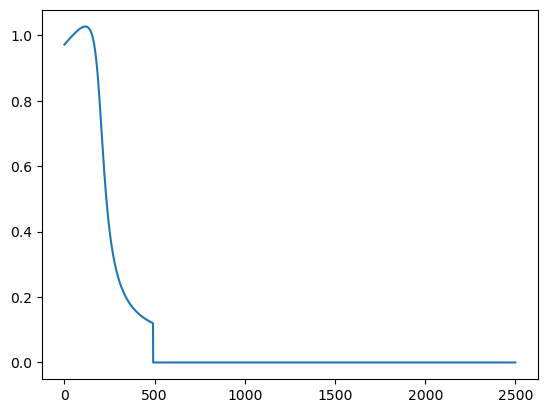

In [206]:

dipoles_0_01 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/dipoles_H2_0_01.npy")
cavity_E_array_0_01 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_01.npy").T

r_data = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_r_array_H2_6311g0_05.npy")


cavity_E_array_0_01 = declutter_E_array(cavity_E_array_0_01, dipoles_0_01, r_data, 3, 1, num_to_declutter=8)

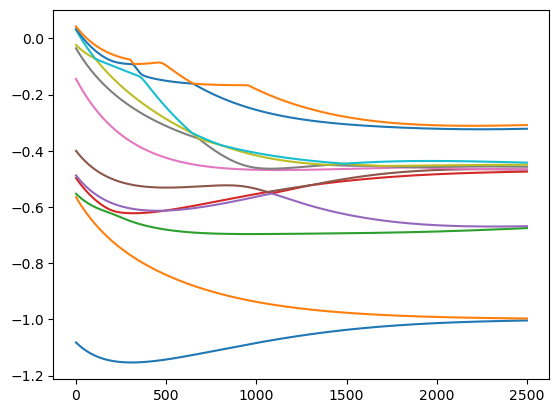

In [193]:
plt.plot(cavity_E_array_0_01)
plt.show()

In [87]:
def build_dipole_mag_matrix(dipoles, n_elec, r_):

    d_matrix = np.zeros((n_elec,n_elec))

    def vector_magnitude(vector):
        return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


    for i in range(n_elec):
        for j in range(n_elec):
            d_matrix[i][j] = vector_magnitude(dipoles[i,j,:,r_])


    d_matrix = d_matrix + d_matrix.T - np.diag(np.diag(d_matrix))
    return d_matrix


In [88]:

# cavity_E_array_0 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0.npy").T
# cavity_E_array_0_05  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_05.npy").T
# cavity_E_array_0_04  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_04.npy").T
# cavity_E_array_0_03  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_03.npy").T
# cavity_E_array_0_01  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_01.npy").T
# cavity_E_array_0_02  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_02.npy").T
# cavity_E_array_0_001  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_001.npy").T
# cavity_E_array_0_005 =np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_005.npy").T

# r_data = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_r_array_H2_6311g0_05.npy")


dipoles_0 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/dipoles_H2_0.npy")
dipoles_0_005 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/dipoles_H2_0_005.npy")
dipoles_0_01 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/dipoles_H2_0_01.npy")
dipoles_0_02= np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/dipoles_H2_0_02.npy")
dipoles_0_03 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/dipoles_H2_0_03.npy")
dipoles_0_04 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/dipoles_H2_0_04.npy")
dipoles_0_05 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/dipoles_H2_0_05.npy")


cavity_E_array_0 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0.npy").T
cavity_E_array_0_005 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_005.npy").T
cavity_E_array_0_01 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_01.npy").T
cavity_E_array_0_02 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_02.npy").T
cavity_E_array_0_03 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_03.npy").T
cavity_E_array_0_04 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_04.npy").T
cavity_E_array_0_05 = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_cavity_arrays_H2_6311g0_05.npy").T




r_data = np.load("/Users/proden/Code/SCQED-PCQED/array_data/H2_omega_0_53/om_0_53_fci_r_array_H2_6311g0_05.npy")



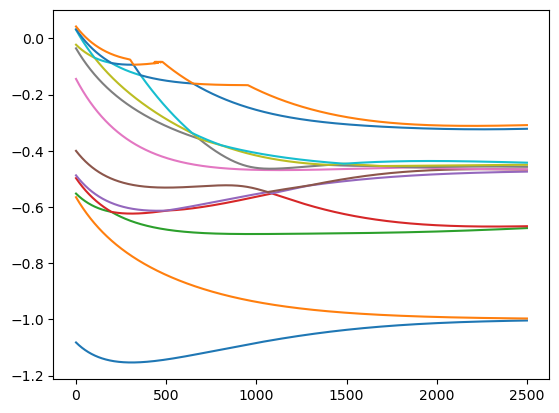

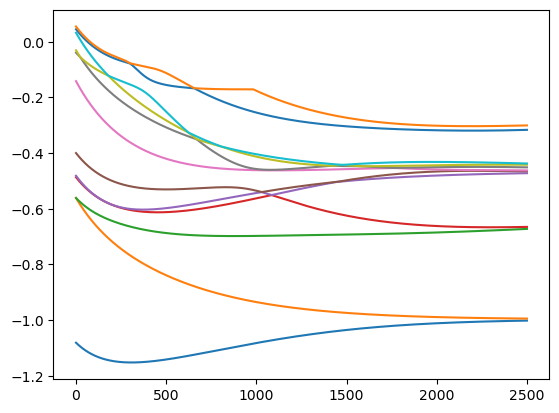

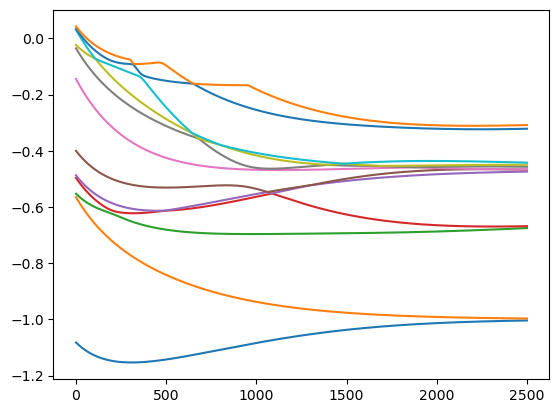

In [89]:
plt.plot(cavity_E_array_0)
plt.show()
plt.plot(cavity_E_array_0_05)
plt.show()
plt.plot(cavity_E_array_0_01)
plt.show()

In [90]:

cavity_E_array_0 = declutter_E_array(cavity_E_array_0, dipoles_0, r_data, 1 ,1, num_to_declutter=12)
cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05, dipoles_0_05, r_data, 1 ,1, num_to_declutter=12)
cavity_E_array_0_04  = declutter_E_array(cavity_E_array_0_04, dipoles_0_04, r_data, 1 ,1, num_to_declutter=12)
cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03, dipoles_0_03, r_data, 1 ,1,num_to_declutter=12)
cavity_E_array_0_02  =declutter_E_array(cavity_E_array_0_02, dipoles_0_02, r_data, 1 ,1, num_to_declutter=12)
cavity_E_array_0_01  = declutter_E_array(cavity_E_array_0_01, dipoles_0_01, r_data, 1 ,1, num_to_declutter=12)
cavity_E_array_0_005  = declutter_E_array(cavity_E_array_0_005, dipoles_0_005, r_data, 1 ,1,num_to_declutter=12)
#cavity_E_array_0_001  = declutter_E_array(cavity_E_array_0_001 , r_data, i*0.1, i, num_to_declutter=9)

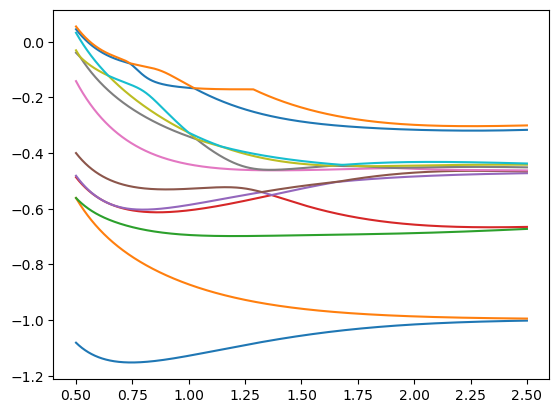

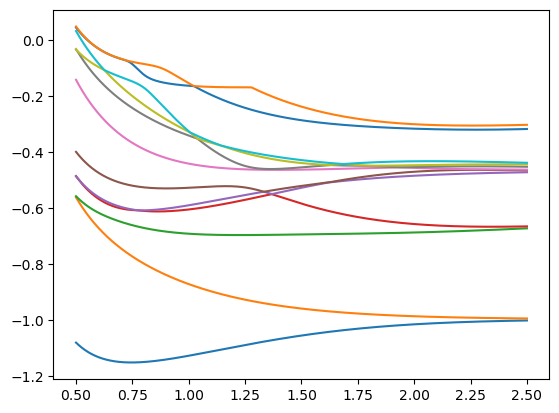

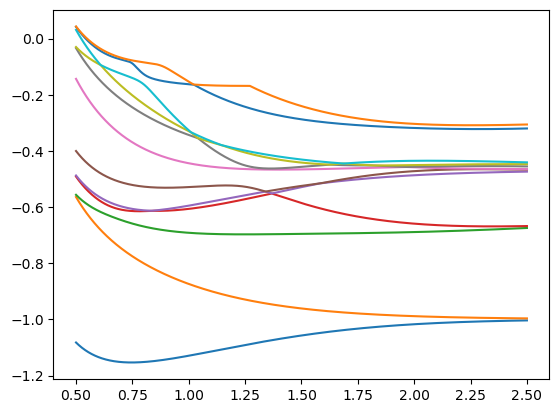

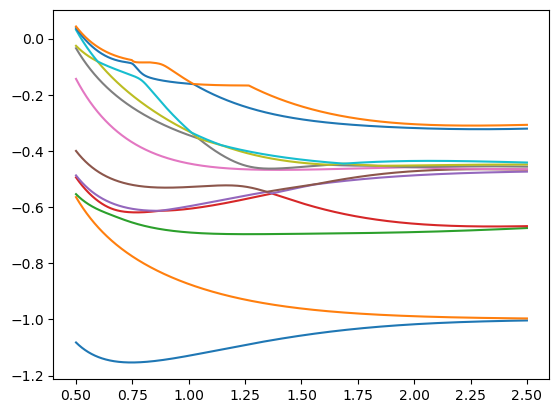

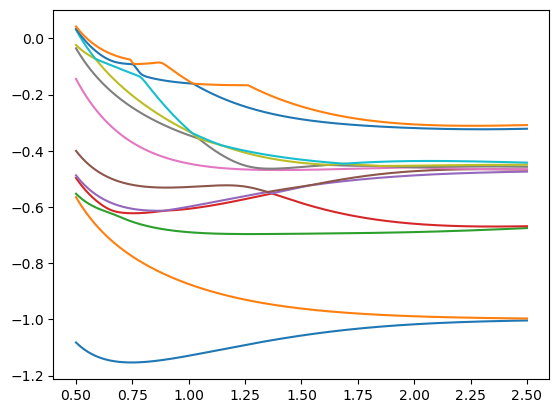

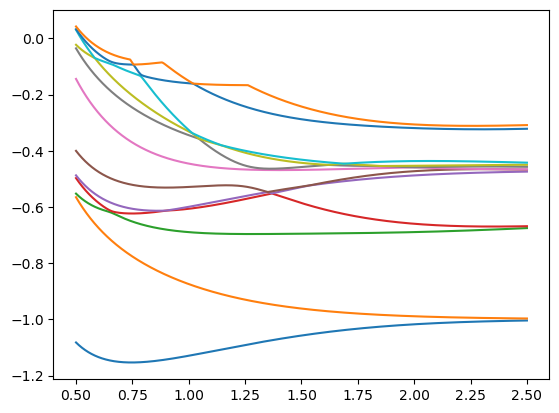

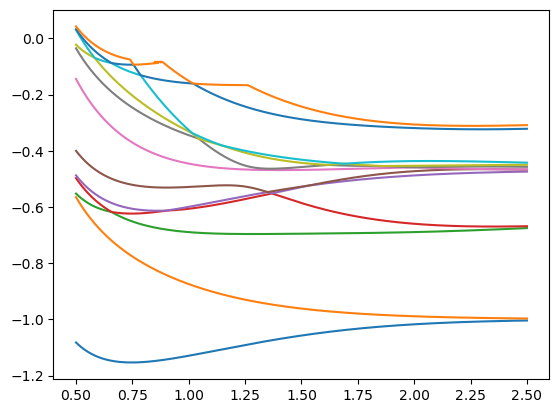

In [91]:
plt.plot(r_data, cavity_E_array_0_05 )
plt.show()
plt.plot(r_data, cavity_E_array_0_04 )
plt.show()
plt.plot(r_data, cavity_E_array_0_03 )
plt.show()
plt.plot(r_data, cavity_E_array_0_02 )
plt.show()
plt.plot(r_data, cavity_E_array_0_01 )
plt.show()
plt.plot(r_data, cavity_E_array_0_005 )
plt.show()
plt.plot(r_data,cavity_E_array_0)
plt.show()

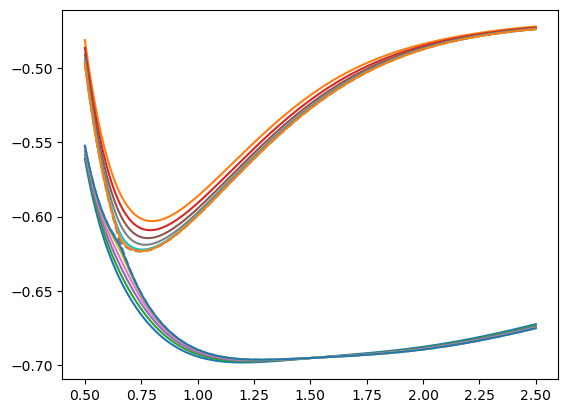

In [18]:

# LP_0_001 = cavity_E_array_0_001[:, 2]
# UP_0_001 = cavity_E_array_0_001[:, 3]

LP_0_005 = cavity_E_array_0_005[:, 2]
UP_0_005 = cavity_E_array_0_005[:, 3]
LP_0_01 = cavity_E_array_0_01[:, 2]
UP_0_01 = cavity_E_array_0_01[:, 3]
LP_0_02 = cavity_E_array_0_02[:, 2]
UP_0_02 = cavity_E_array_0_02[:, 3]
LP_0_03 = cavity_E_array_0_03[:, 2]
UP_0_03 = cavity_E_array_0_03[:, 3]
LP_0_04 = cavity_E_array_0_04[:, 2]
UP_0_04 = cavity_E_array_0_04[:,4]
LP_0_05 = cavity_E_array_0_05[:, 2]
UP_0_05 = cavity_E_array_0_05[:, 4]





fci_S0 = cavity_E_array_0[:,0]
fci_S1 = cavity_E_array_0[:,3]
plt.plot(r_data, fci_S0 + 0.53, color = 'grey', linestyle = 'dashed')
plt.plot(r_data, fci_S1, 'grey', linestyle = 'dashed')
plt.plot(r_data, LP_0_05)
plt.plot(r_data, UP_0_05)
plt.plot(r_data, LP_0_04)
plt.plot(r_data, UP_0_04)
plt.plot(r_data, LP_0_03)
plt.plot(r_data, UP_0_03)
plt.plot(r_data, LP_0_02)
plt.plot(r_data, UP_0_02)
plt.plot(r_data, LP_0_01)
plt.plot(r_data, UP_0_01)
plt.plot(r_data, LP_0_005)
plt.plot(r_data, UP_0_005)
# plt.plot(r_data, LP_0_001)
# plt.plot(r_data, UP_0_001)
plt.show()

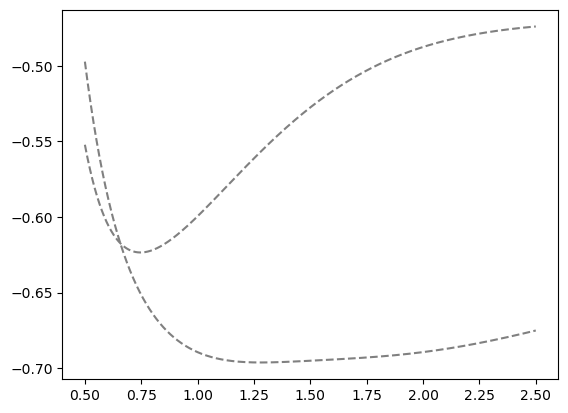

In [19]:
fci_S0 = cavity_E_array_0[:,0]
fci_S1 = cavity_E_array_0[:,3]
plt.plot(r_data, fci_S0 + 0.53, color = 'grey', linestyle = 'dashed')
plt.plot(r_data, fci_S1, 'grey', linestyle = 'dashed')
plt.show()

In [20]:
print(np.argmin(fci_S0))

308


In [21]:

hbar = 1

# number of grid points 
N = 2001


def get_fd_wfn(x, V_y: np.array, use_5_point_stencil = False):

    hbar = 1


    # define grid spacing h
    h = x[1]-x[0]

    # create arrays for T, V, and H - we truncate the smallest and largest grid points where 
    # the centered finite difference derivatives cannot be defined
    T = np.zeros((N-2, N-2))
    V = np.zeros((N-2, N-2))
    H = np.zeros((N-2, N-2))

    # this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy


    if not use_5_point_stencil:
        for i in range(N-2):
            for j in range(N-2):
                if i==j:
                    T[i,j]= -2
                elif np.abs(i-j)==1:
                    T[i,j]=1
                else:
                    T[i,j]=0

        T = -T *( hbar ** 2 / (2 * mu_au* h**2))
        #T =  (- (hbar ** 2) / (2* mu_kg)) *  (1 / ( h**2)) * joule_to_hartree  * T


    elif use_5_point_stencil:
        for i in range(N-2):
            for j in range(N-2):
                if i==j:
                    T[i,j]= -30
                elif np.abs(i-j)==1:
                    T[i,j]=16
                elif np.abs(i-j)==2:
                    T[i,j]=-1

        T = -T *  ((hbar ** 2) / (2* mu_au))*  (1 / ( 12 * h**2)) 


    for i in range(N-2):
        for j in range(N-2):
            if i==j:
                V[i,j]= V_y[i+1]
            else:
                V[i,j]=0
                
    H = T + V

    #print((-T * hbar ** 2 / (2 * mu_kg* h**2)) * (2.294 * 10 ** 17))
    #print(V)

    vals, vecs = np.linalg.eigh(H)

    if np.average(vecs[:, 0]) < 0:
        vecs = vecs * -1

    return vals, vecs

In [22]:
#FCF calculator
def get_fcf_matrix(potential_1, potential_2, r_data, matrix_size = 6, potential_1_is_groundstate = False):

    #geneerate 2 sets of wavefunctions for the potentials

    r_data_au = r_data / psi4.constants.bohr2angstroms

    min_potential_1_loc = np.argmin(potential_1[:])
    r_eq_au =r_data_au[potential_1.argmin()]

    print("r_eq_au : " , r_eq_au)


    # Fitting S0 PES to a quintic polynomial

    poly = np.poly1d(np.polyfit(r_data_au, potential_1, 14))

    poly_array = np.asarray(poly)


    #Taking first and second derivative of S0 PES and evaluating at r_eq
    first_derivative = poly.deriv()
    second_derivative = first_derivative.deriv()
    k_au = second_derivative(r_eq_au)
    print("k_au: ", k_au)


    angstrom_to_bohr = 1.88973
    x_min = r_data_au[0]
    x_max = r_data_au[-1]

    hbar = 1

    # number of grid points 
    N = 2001
    # define grid
    x = np.linspace(x_min, x_max, N)

    V_y = np.polyval(np.asarray(poly), (x))


    vals1, vecs1 = get_fd_wfn(x, V_y, use_5_point_stencil=True)
    #vals1, vecs1 = get_fd_wfn(x, V_y)



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('bond length (m)')
    ax1.set_ylabel('wfn', color=color)
    ax1.plot(x[1:N-1], vecs1[:,0], 'r', label = "$\psi_0$")
    ax1.plot(x[1:N-1], vecs1[:,1], 'b',label = "$\psi_1$" )
    ax1.plot(x[1:N-1], vecs1[:,2], 'g',label = "$\psi_2$")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('energy (hartree)', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_data_au, potential_1, 'bo', label='PES_1')
    ax2.plot(r_data_au, poly(r_data_au), 'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()


    min_potential_2_loc = np.argmin(potential_2[:])
    r_eq_au =r_data_au[min_potential_2_loc]

    print("r_eq_au : " , r_eq_au)


    # Fitting S0 PES to a quintic polynomial

    #can use this line to only fit to bottom of well for cubic and harmonic
    #poly = np.poly1d(np.polyfit(r_data_meters[50:100], fci_S0[50:100], 4))

    poly = np.poly1d(np.polyfit(r_data_au, potential_2, 14))

    poly_array = np.asarray(poly)


    #Taking first and second derivative of S0 PES and evaluating at r_eq
    first_derivative = poly.deriv()
    second_derivative = first_derivative.deriv()
    k_au = second_derivative(r_eq_au)
    print("k_au: ", k_au)


    angstrom_to_bohr = 1.88973
    x_min = r_data_au[0]
    x_max = r_data_au[-1]

    hbar = 1

    # number of grid points 
    N = 2001
    # define grid
    x = np.linspace(x_min, x_max, N)

    V_y = np.polyval(np.asarray(poly), (x))


    vals2, vecs2 = get_fd_wfn(x, V_y, use_5_point_stencil=True)
    #vals2, vecs2 = get_fd_wfn(x, V_y)



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('bond length')
    ax1.set_ylabel('wfn', color=color)
    ax1.plot(x[1:N-1], vecs2[:,0], 'r',label = "$\psi_0$")
    ax1.plot(x[1:N-1], vecs2[:,1], 'b',label = "$\psi_1$")
    ax1.plot(x[1:N-1], vecs2[:,2], 'g', label = "$\psi_2$")

    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('energy (hartree)', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_data_au, potential_2, 'bo', label='PES_2')
    ax2.plot(r_data_au, poly(r_data_au), 'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()


    FCF_matrix = np.zeros((matrix_size,matrix_size))

    for i in range(FCF_matrix.shape[0]):
        for j in range(FCF_matrix.shape[0]):

            FCF_matrix[i][j] = np.trapz(vecs1[:,i] * vecs2[:,j]) 
            FCF = np.absolute(FCF_matrix) ** 2 

    return FCF




<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\p'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:117: SyntaxWarning: invalid escape sequence '\p'
<>:118: SyntaxWarning: invalid escape sequence '\p'
<>:119: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\p'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:117: SyntaxWarning: invalid escape sequence '\p'
<>:118: SyntaxWarning: invalid escape sequence '\p'
<>:119: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/j1g5yyj51l1_gtt0b347d_gwjf45wq/T/ipykernel_79803/1365804905.py:52: SyntaxWarning: invalid escape sequence '\p'
  ax1.plot(x[1:N-1], vecs1[:,0], 'r', label = "$\psi_0$")
/var/folders/mb/j1g5yyj51l1_gtt0b347d_gwjf45wq/T/ipykernel_79803/1365804905.py:53: SyntaxWarning: invalid escape sequence '\p'
  ax1.plot(x[1:N-1], vecs1[:,1], 'b',label = "$\psi_1$" )
/var/folders

r_eq_au :  1.410677905979023
k_au:  0.3472968460943804


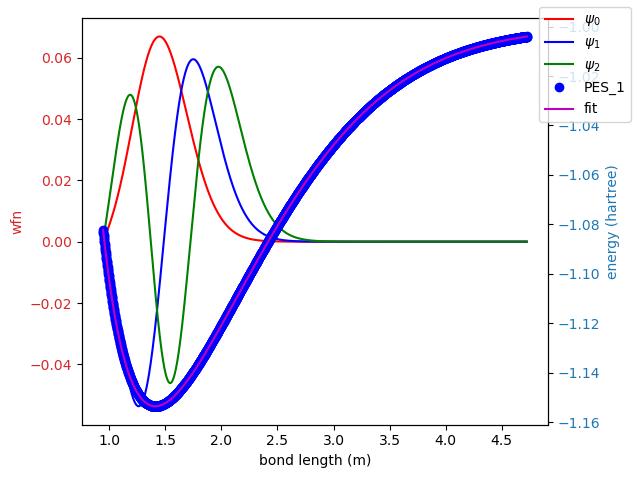

r_eq_au :  1.5074706006803444
k_au:  0.3628114993492346


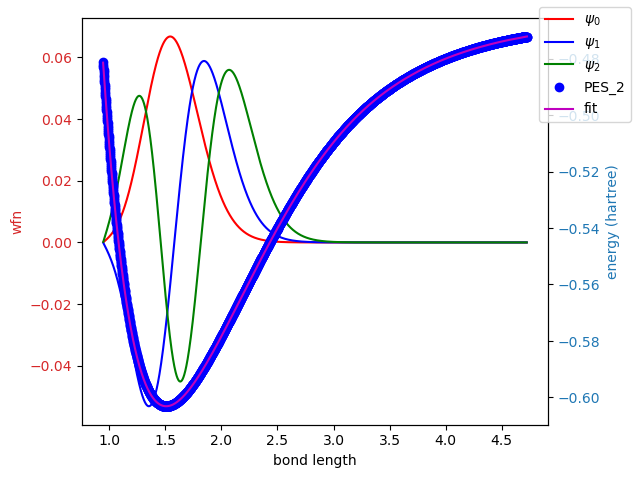

r_eq_au :  1.410677905979023
k_au:  0.3472968460943804


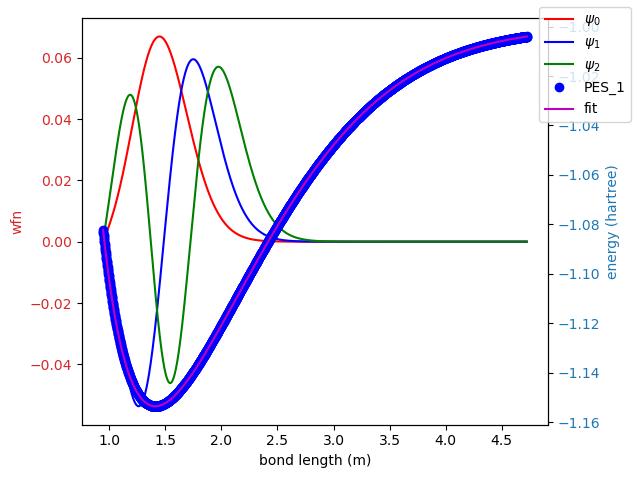

r_eq_au :  1.4923467421332628
k_au:  0.3828035438742359


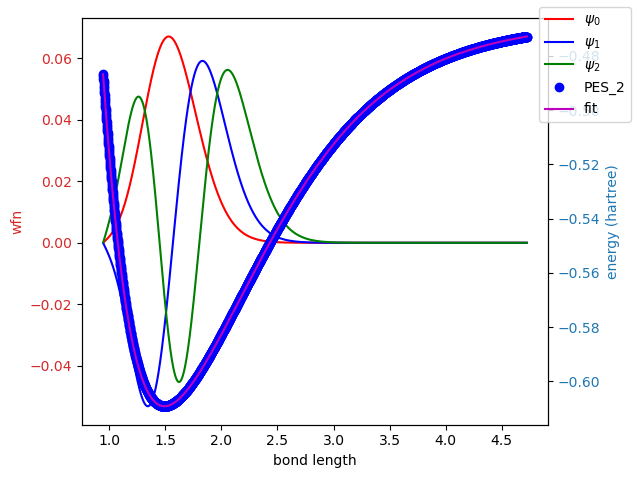

r_eq_au :  1.410677905979023
k_au:  0.3472968460943804


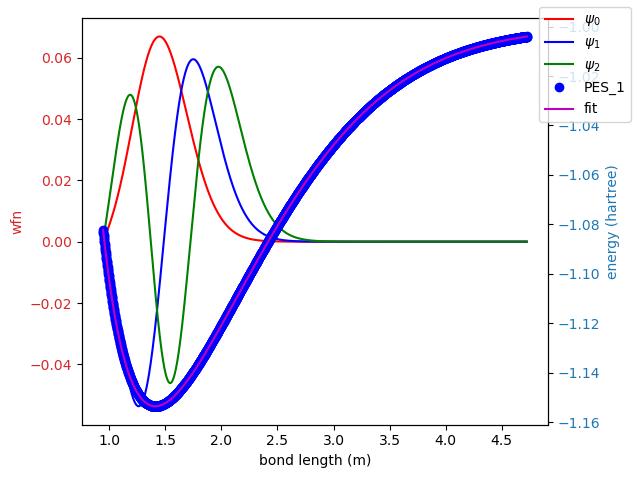

r_eq_au :  1.472685726022057
k_au:  0.4095192395546974


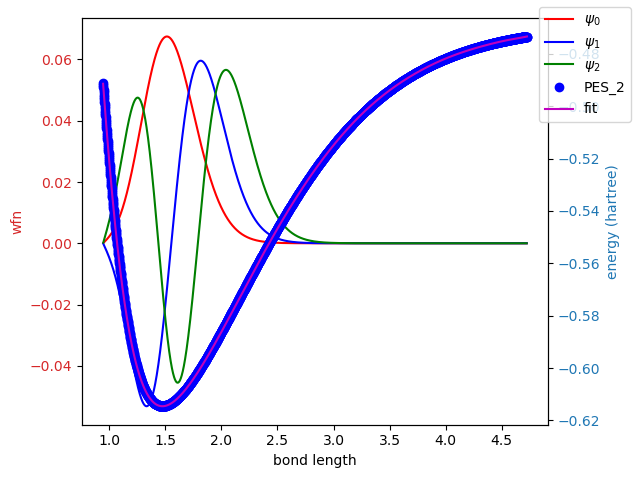

r_eq_au :  1.410677905979023
k_au:  0.3472968460943804


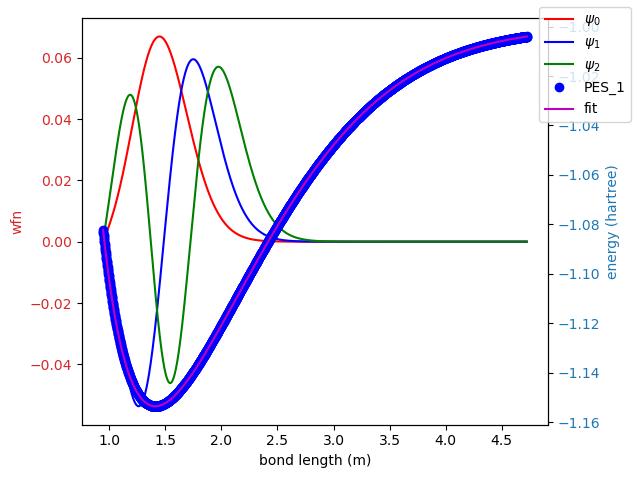

r_eq_au :  1.451512324056143
k_au:  0.43790844841896615


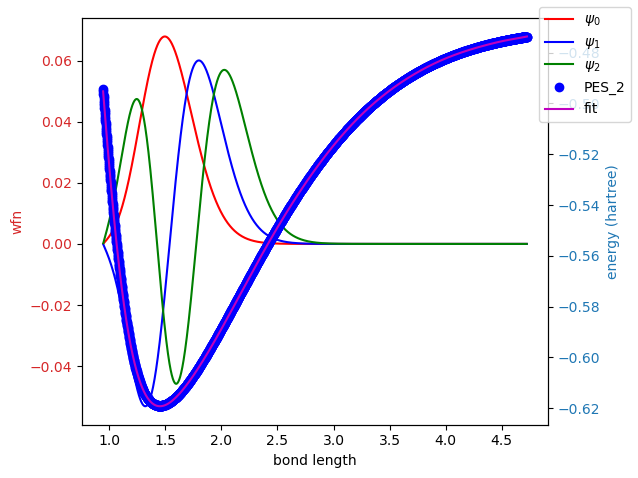

r_eq_au :  1.410677905979023
k_au:  0.3472968460943804


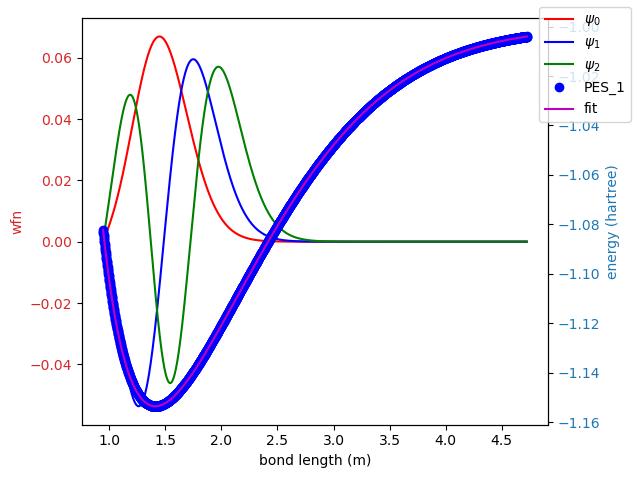

r_eq_au :  1.4258017645261045
k_au:  0.47882158637185057


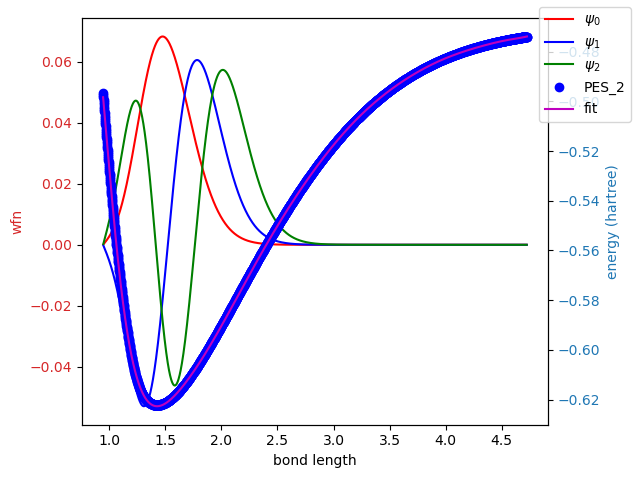

r_eq_au :  1.410677905979023
k_au:  0.3472968460943804


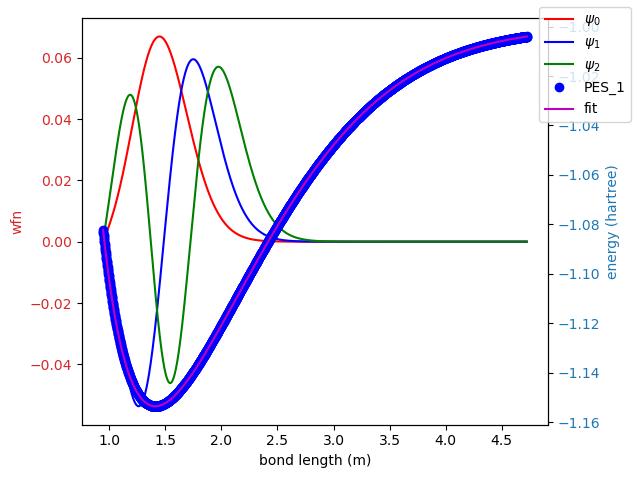

r_eq_au :  1.4152150635431475
k_au:  0.49658701778025716


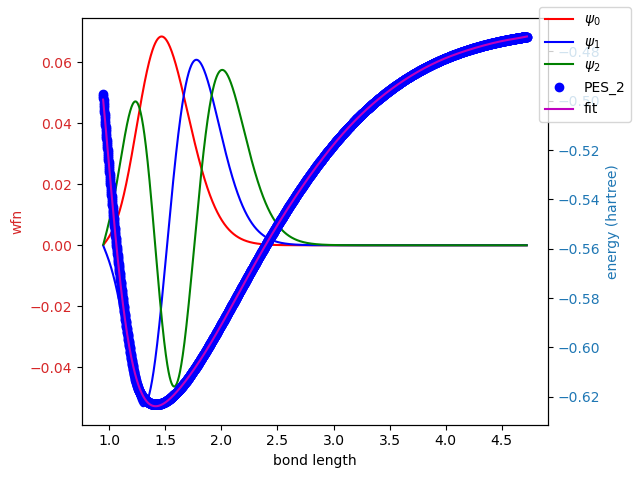

In [23]:

fcf_0_05 = get_fcf_matrix(fci_S0,UP_0_05, r_data, 6)

fcf_0_04 = get_fcf_matrix(fci_S0,UP_0_04, r_data, 6)

fcf_0_03 = get_fcf_matrix(fci_S0,UP_0_03, r_data, 6)

fcf_0_02 = get_fcf_matrix(fci_S0,UP_0_02, r_data, 6)

fcf_0_01 = get_fcf_matrix(fci_S0,UP_0_01, r_data, 6)
fcf_0_005 = get_fcf_matrix(fci_S0,UP_0_005, r_data, 6)

In [24]:
min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_005)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_01)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_02)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_03)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_04)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_05)
x=x.style.background_gradient(cmap=cm)
display(x)

,0,1,2,3,4,5
0,0.992153,0.003872,0.001723,0.000991,0.000558,0.000303
1,0.005080,0.970468,0.014928,0.004505,0.002058,0.001123
2,0.001630,0.020069,0.943621,0.020996,0.006480,0.002867
3,0.000689,0.003527,0.031234,0.926032,0.022939,0.007048
4,0.000278,0.001145,0.005377,0.036968,0.916389,0.023798
5,0.000106,0.000481,0.001667,0.006331,0.039959,0.911814


,0,1,2,3,4,5
0,0.988150,0.007040,0.002404,0.001159,0.000585,0.000297
1,0.008985,0.960421,0.019611,0.005580,0.002394,0.001222
2,0.001908,0.026765,0.929957,0.025971,0.007655,0.003261
3,0.000629,0.003906,0.039342,0.911106,0.027596,0.008232
4,0.000216,0.001119,0.005785,0.045350,0.901654,0.027921
5,0.000073,0.000421,0.001646,0.006857,0.047992,0.897562


,0,1,2,3,4,5
0,0.975417,0.017483,0.004269,0.001569,0.000656,0.000293
1,0.021849,0.929448,0.033600,0.008626,0.003265,0.001467
2,0.002157,0.047411,0.889586,0.040409,0.011088,0.004369
3,0.000435,0.004324,0.063942,0.867050,0.041292,0.011733
4,0.000105,0.000916,0.006332,0.071273,0.856950,0.040600
5,0.000027,0.000268,0.001451,0.007723,0.073923,0.852688


,0,1,2,3,4,5
0,0.958785,0.031321,0.006525,0.002031,0.000745,0.000303
1,0.039034,0.889470,0.051216,0.012445,0.004292,0.001752
2,0.001891,0.074417,0.838432,0.058263,0.015520,0.005767
3,0.000241,0.003983,0.096203,0.810753,0.058468,0.016320
4,0.000040,0.000613,0.006058,0.106233,0.798030,0.057145
5,0.000008,0.000138,0.001100,0.007724,0.110573,0.790946


,0,1,2,3,4,5
0,0.940719,0.046327,0.008977,0.002523,0.000848,0.000321
1,0.057827,0.846079,0.070006,0.016693,0.005417,0.002068
2,0.001334,0.104111,0.782783,0.077207,0.020563,0.007362
3,0.000107,0.003064,0.132288,0.748496,0.076933,0.021629
4,0.000012,0.000342,0.004988,0.146611,0.730785,0.075521
5,0.000002,0.000059,0.000723,0.006707,0.154904,0.717259


,0,1,2,3,4,5
0,0.922930,0.060977,0.011471,0.003027,0.000957,0.000346
1,0.076279,0.803345,0.088215,0.021085,0.006589,0.002403
2,0.000754,0.133539,0.727488,0.095539,0.025869,0.009069
3,0.000036,0.001957,0.168804,0.685415,0.094996,0.027303
4,0.000002,0.000157,0.003501,0.188840,0.660365,0.094026
5,0.000000,0.000020,0.000417,0.004977,0.203496,0.636207


In [25]:
# td_0_005 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_005.npy")[0,3,:,314]
# td_0_01 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_01.npy")[0,3,:,314]
# td_0_02 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_02.npy")[0,3,:,314]
# td_0_03 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_03.npy")[0,3,:,314]
# td_0_04 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_04.npy")[0,3,:,314]
# td_0_05 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_05.npy")[0,3,:,314]
# td_0_1 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_1.npy")[0,3,:,314]




# def vector_magnitude(vector):
#     return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


# td_0_005 = vector_magnitude(td_0_005)**2
# td_0_01 = vector_magnitude(td_0_01)**2
# td_0_02 = vector_magnitude(td_0_02)**2
# td_0_03 = vector_magnitude(td_0_03)**2
# td_0_04 = vector_magnitude(td_0_04)**2
# td_0_05 = vector_magnitude(td_0_05)**2
# td_0_1= vector_magnitude(td_0_1)**2


# print(td_0_005)
# print(td_0_01)
# print(td_0_02)
# print(td_0_03)
# print(td_0_04)
# print(td_0_05)
# print(td_0_1)


In [26]:
# min_val, max_val = 0, 15
# cm = sns.light_palette("blue", as_cmap=True)
# x=pd.DataFrame(td_0_005*fcf_0_005)
# x=x.style.background_gradient(cmap=cm)
# display(x)

# min_val, max_val = 0, 15
# cm = sns.light_palette("blue", as_cmap=True)
# x=pd.DataFrame(td_0_01*fcf_0_01)
# x=x.style.background_gradient(cmap=cm)
# display(x)

# min_val, max_val = 0, 15
# cm = sns.light_palette("blue", as_cmap=True)
# x=pd.DataFrame(td_0_02*fcf_0_02)
# x=x.style.background_gradient(cmap=cm)
# display(x)

# min_val, max_val = 0, 15
# cm = sns.light_palette("blue", as_cmap=True)
# x=pd.DataFrame(td_0_03 * fcf_0_03)
# x=x.style.background_gradient(cmap=cm)
# display(x)

# min_val, max_val = 0, 15
# cm = sns.light_palette("blue", as_cmap=True)
# x=pd.DataFrame(td_0_04* fcf_0_04)
# x=x.style.background_gradient(cmap=cm)
# display(x)

# min_val, max_val = 0, 15
# cm = sns.light_palette("blue", as_cmap=True)
# x=pd.DataFrame(td_0_05 * fcf_0_05)
# x=x.style.background_gradient(cmap=cm)
# display(x)